<a href="https://colab.research.google.com/github/LikeRainDay/colab-demo/blob/main/%E5%9B%BE%E5%83%8F/%E9%A3%8E%E6%A0%BC%E8%BF%81%E7%A7%BB%E9%AA%8C%E8%AF%81%E7%A0%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

> 本代码主要通过[neural-style-tf](https://github.com/cysmith/neural-style-tf)库，实现对图片的风格迁移，通过其mask的实现内容，来进行生成验证码的风格迁移内容。

In [ ]:
# 初始化设定参数
# image size
IMAGE_SIZE = 500

In [ ]:
# 上传验证码风格迁移的背景图片

from google.colab import files

back_img = files.upload()

Saving u=1982821860,1282526719&fm=26&gp=0.jpg to u=1982821860,1282526719&fm=26&gp=0 (1).jpg


In [ ]:
import os

BACK_IMAGE_FN = list(back_img)[0]
BACK_IMAGE_FN_temp = BACK_IMAGE_FN.strip().replace(" ", "_")

if BACK_IMAGE_FN != BACK_IMAGE_FN_temp:
  os.rename(BACK_IMAGE_FN, BACK_IMAGE_FN_temp)
  BACK_IMAGE_FN = BACK_IMAGE_FN_temp
  
print("back image filename :", BACK_IMAGE_FN)

back image filename : u=1982821860,1282526719&fm=26&gp=0.jpg


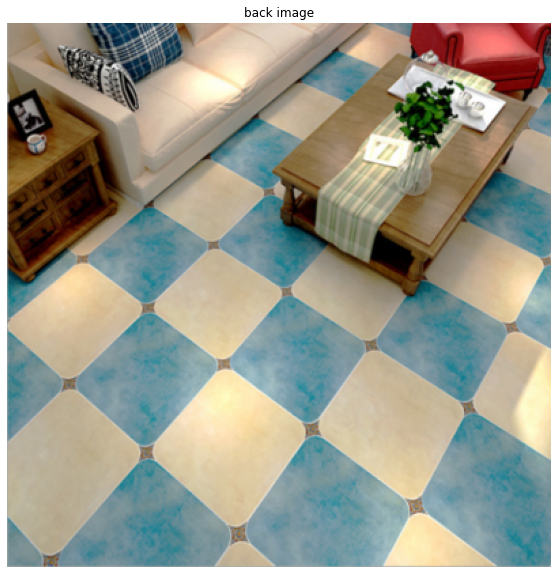

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
img = plt.imread(BACK_IMAGE_FN)
plt.axis('off')
plt.title('back image')
plt.imshow(img)

# 生成content_image的验证码mask

> 主要用来进行生成需要进行风格迁移的验证码mask图片内容


In [ ]:
# 随机文字
import random

def Unicode():
    val = random.randint(0x4e00, 0x9fbf)
    return chr(val)

# 字体库存在无法识别的文字导致无法使用随机字体
# random_text = [Unicode(), Unicode(), Unicode(), Unicode()]
random_text = ["走", "我", "放", "心"]
print(random_text)

['走', '我', '放', '心']


In [ ]:
# BGR 转换为RGB
import cv2

def bgr_2_rgb(mat):
   return cv2.cvtColor(mat, cv2.COLOR_BGR2RGB)

def cvImageRead(path):
  img_OpenCV = cv2.imread(path)
  return bgr_2_rgb(img_OpenCV)

In [ ]:
# 字体下载路径
!wget http://sentyfont.com/index_htm_files/HanyiSentyPailouArch.ttf

--2020-10-04 11:06:39--  http://sentyfont.com/index_htm_files/HanyiSentyPailouArch.ttf
Resolving sentyfont.com (sentyfont.com)... 67.20.72.147
Connecting to sentyfont.com (sentyfont.com)|67.20.72.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9603268 (9.2M) [font/ttf]
Saving to: ‘HanyiSentyPailouArch.ttf’

HanyiSentyPailouArc 100%[===================>]   9.16M  6.57MB/s    in 1.4s    

2020-10-04 11:06:41 (6.57 MB/s) - ‘HanyiSentyPailouArch.ttf’ saved [9603268/9603268]



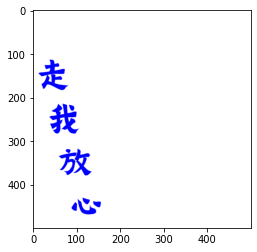

In [ ]:
# 生成白色底板的验证码图片
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import numpy as np
import cv2
import os
 
w = IMAGE_SIZE
h = IMAGE_SIZE
 
# 字体来源  http://d.zt6.com.cn/file/22577433-447816623 
font = ImageFont.truetype('/content/HanyiSentyPailouArch.ttf', 80)

a = np.zeros((h,w,3), np.uint8)
for i in range(h):
  for j in range(w):
    for k in range(3):
      a[i][j][k] = 255

img_PIL = Image.fromarray(cv2.cvtColor(a, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(img_PIL)

for i in range(len(random_text)):
  draw.text((10+i*25, 100+i*100), random_text[i], font=font, fill=(255, 0, 0))

img_OpenCV = cv2.cvtColor(np.asarray(img_PIL), cv2.COLOR_RGB2BGR)

plt.imshow(img_OpenCV)
plt.show()

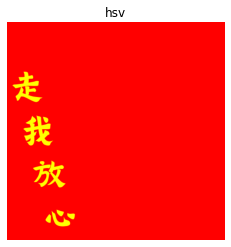

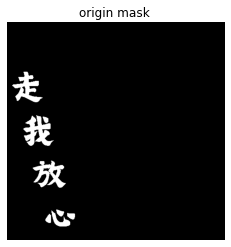

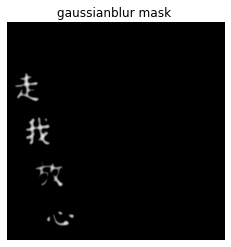

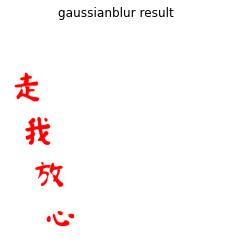

In [ ]:
# 生成验证码mask逻辑内容 根据生成的验证码内容
import skimage.exposure
# convert to hsv
hsv = cv2.cvtColor(img_OpenCV, cv2.COLOR_BGR2HSV)

plt.axis('off')
plt.title('hsv')
plt.imshow(bgr_2_rgb(hsv))
plt.show()

# 这里只采集hsv后红色的BGR颜色
range1 = (0,0,255)
range2 = (0,0,255)
mask = cv2.inRange(hsv, range1, range2)
origin_mask = 255 - mask
plt.axis('off')
plt.title('origin mask ')
plt.imshow(bgr_2_rgb(origin_mask))
plt.show()

# apply morphology opening to mask
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(origin_mask, cv2.MORPH_ERODE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# antialias mask
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
mask = skimage.exposure.rescale_intensity(mask, in_range=(127.5,255), out_range=(0,255))

result = img_OpenCV.copy()
result[mask==0] = (255,255,255)

plt.axis('off')
plt.title('gaussianblur mask ')
plt.imshow(bgr_2_rgb(mask))
plt.show()

plt.axis('off')
plt.title('gaussianblur result')
plt.imshow(bgr_2_rgb(result))
plt.show()


In [ ]:
# 从上面的结果看来 最好的mask 为 origin mask 。 因此我们使用origin作为mask 来进行风格迁移的遮挡。

# 预备neural-style-tf模型的导入

In [ ]:
# 下载模型代码 https://github.com/cysmith/neural-style-tf
!git clone https://github.com/cysmith/neural-style-tf.git

Cloning into 'neural-style-tf'...
remote: Enumerating objects: 893, done.
remote: Total 893 (delta 0), reused 0 (delta 0), pack-reused 893
Receiving objects: 100% (893/893), 85.23 MiB | 14.75 MiB/s, done.
Resolving deltas: 100% (451/451), done.


In [ ]:
# 下载模型数据
!wget https://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
!mv /content/imagenet-vgg-verydeep-19.mat /content/neural-style-tf/

--2020-10-04 11:07:34--  https://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
Resolving www.vlfeat.org (www.vlfeat.org)... 64.90.48.57
Connecting to www.vlfeat.org (www.vlfeat.org)|64.90.48.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534904783 (510M)
Saving to: ‘imagenet-vgg-verydeep-19.mat’

imagenet-vgg-veryde 100%[===================>] 510.12M  20.4MB/s    in 26s     

2020-10-04 11:08:01 (19.5 MB/s) - ‘imagenet-vgg-verydeep-19.mat’ saved [534904783/534904783]



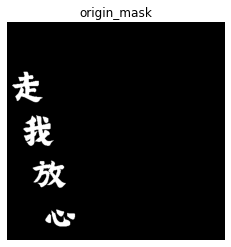

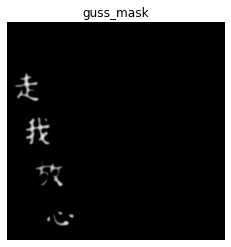

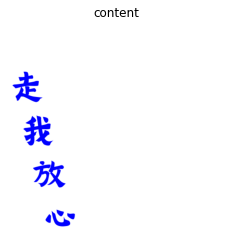

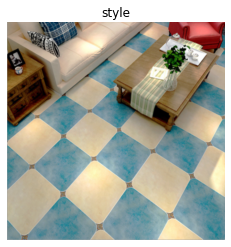

True

In [ ]:
# 保存我们的照片内容 使用模型命令行进行处理
origin_mask_path = '/content/origin_mask.png'
guss_mask_path = '/content/guss_mask.png'
content_path = '/content/content.png'
style_path = '/content/style.png'

plt.axis('off')
plt.title('origin_mask')
plt.imshow(bgr_2_rgb(origin_mask))
plt.show()


plt.axis('off')
plt.title('guss_mask')
plt.imshow(bgr_2_rgb(mask))
plt.show()


plt.axis('off')
plt.title('content')
plt.imshow(img_OpenCV)
plt.show()

plt.axis('off')
plt.title('style')
plt.imshow(cvImageRead(BACK_IMAGE_FN))
plt.show()



cv2.imwrite(origin_mask_path, bgr_2_rgb(origin_mask))
cv2.imwrite(guss_mask_path, bgr_2_rgb(mask))
cv2.imwrite(content_path, img_OpenCV)
cv2.imwrite(style_path, cvImageRead(BACK_IMAGE_FN))

# 进行生成风格迁移后的验证码内容

In [ ]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
! cd /content/neural-style-tf &&  python neural_style.py --content_img  /content/style.png \
                       --style_imgs /content/content.png \
                       --style_mask  \
                       --style_mask_imgs /content/origin_mask.png \
                       --img_output_dir /content/image_output \
                       --content_layer_weights 0.05 \
                       --style_imgs_weights 0.05 \
                       --max_size 1000 \
                       --max_iterations 100 \
                       --original_colors \
                       --device /gpu:0 \
                       --verbose;



---- RENDERING SINGLE IMAGE ----


2020-10-04 11:43:27.667550: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-04 11:43:27.707091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-04 11:43:27.707767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-10-04 11:43:27.708037: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-10-04 11:43:27.709728: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-10-04 11:43:27.711236: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened 

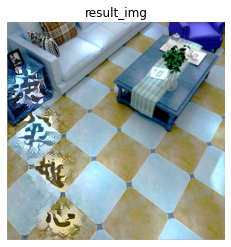

In [ ]:
# 输出结果
result_img = cvImageRead('/content/image_output/result/result.png')
plt.axis('off')
plt.title('result_img')
plt.imshow(result_img)
plt.show()